In [2]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [96]:
lines= pd.read_table('san.txt', names=['eng', 'san'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [0]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.san=lines.san.apply(lambda x: x.lower())

In [0]:
# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.san=lines.san.apply(lambda x: re.sub("'", '', x))

In [0]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.san=lines.san.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.san = lines.san.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [0]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.san=lines.san.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.san=lines.san.apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences
lines.eng = lines.eng.apply(lambda x : 'START_ '+ x + ' _END')

In [103]:
lines.sample(10)

,eng,san
17910,START_ is that black bag yours _END,ती काळी बॅग तुमची आहे का
32709,START_ australia is smaller than south america...,ऑस्ट्रेलिया दक्षिण अमेरिकेपेक्षा लहान आहे
416,START_ wait here _END,इथे थांबा
2696,START_ give me my bag _END,मला माझी पिशवी द्या
7048,START_ is that your room _END,ती तुझी खोली आहे का
29978,START_ we have five fingers on each hand _END,आपल्याला प्रत्येक हातात पाच बोटं असतात
14944,START_ this bag is too heavy _END,ही बॅग खूपच जड आहे
35808,START_ i never for a moment imagined that i wo...,मी या वयातही असलं काहीतरी करत असेन असा एका क्ष...
32540,START_ the only thing i have now are memories ...,माझ्याकडे आता काय उरलंय तर फक्त आठवणी
17305,START_ did you call the police _END,तुम्ही पोलिसांना फोन केलात का


In [0]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_san_words=set()
for san in lines.san:
    for word in san.split():
        if word not in all_san_words:
            all_san_words.add(word)

In [105]:
# Max Length of source sequence
lenght_list=[]
for l in lines.san:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

35

In [106]:
# Max Length of target sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

36

In [107]:
target_words = sorted(list(all_eng_words))
input_words = sorted(list(all_san_words))
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens = len(all_san_words)
num_encoder_tokens, num_decoder_tokens

(13007, 5473)

In [0]:
num_decoder_tokens += 1

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [111]:
lines = shuffle(lines)
lines.head(10)

,eng,san
35794,START_ if cleopatras nose had been shorter the...,जर क्लिओपात्राचं नाक थोडं छोटं असतं तर जगाचा इ...
18786,START_ youre breaking the law _END,तू कायदा मोडत आहेस
23339,START_ your chicken soup is great _END,तुझं चिकन सूप मस्त असतं
14534,START_ im reading this book _END,मी हे पुस्तक वाचतोय
20823,START_ i get up at six every day _END,मी रोज सहा वाजता उठतो
33521,START_ if you dont hurry youll miss the train ...,घाई केली नाहीत तर तमची ट्रेन सुटेल
29281,START_ what happened wasnt toms fault _END,जे काही घडलं त्यात टॉमची चूक नव्हती
23460,START_ do you understand this book _END,हे पुस्तक तुला समजलं का
32795,START_ i dont want to translate that sentence ...,मला त्या वाक्याचा अनुवाद करायचा नाहीये
6358,START_ are you forgetful _END,तू विसराळू आहेस का


In [112]:
# Train - Test Split
X, y =  lines.san, lines.eng
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((32248,), (3584,))

In [0]:
### Save the train and test dataframes
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [0]:
latent_dim = 50

In [24]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

W0827 05:33:33.346143 139929746868096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 05:33:33.384639 139929746868096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 05:33:33.394333 139929746868096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 05:33:33.624025 139929746868096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

W0827 05:33:46.247920 139929746868096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 05:33:46.271605 139929746868096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 420

In [36]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/420
251/251 [==============================] - 67s 265ms/step - loss: 4.6997 - acc: 0.2380 - val_loss: 4.6325 - val_acc: 0.2484
Epoch 2/420
251/251 [==============================] - 66s 264ms/step - loss: 4.4461 - acc: 0.2625 - val_loss: 4.4108 - val_acc: 0.2699
Epoch 3/420
251/251 [==============================] - 66s 265ms/step - loss: 4.2156 - acc: 0.2879 - val_loss: 4.2185 - val_acc: 0.2956
Epoch 4/420
251/251 [==============================] - 66s 263ms/step - loss: 3.9982 - acc: 0.3201 - val_loss: 4.0215 - val_acc: 0.3262
Epoch 5/420
251/251 [==============================] - 66s 262ms/step - loss: 3.7923 - acc: 0.3500 - val_loss: 3.8413 - val_acc: 0.3525
Epoch 6/420
251/251 [==============================] - 66s 264ms/step - loss: 3.6139 - acc: 0.3745 - val_loss: 3.6972 - val_acc: 0.3707
Epoch 7/420
251/251 [==============================] - 66s 264ms/step - loss: 3.4603 - acc: 0.3942 - val_loss: 3.5804 - val_acc: 0.3862
Epoch 8/420
251/251 [===========================

In [0]:
### saving model
model.save_weights('nmt_weights2.h5')

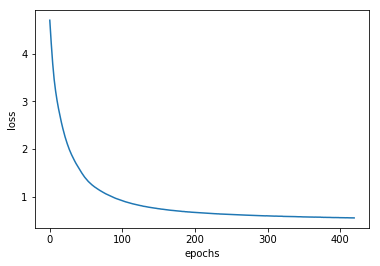

In [77]:
### Ploting epoch vs loss
plt.plot(range(len(model.history.history['val_loss'])),model.history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

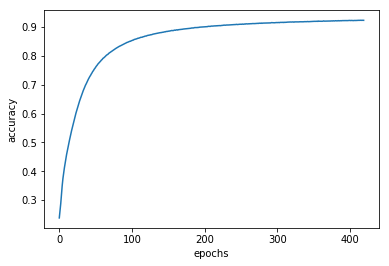

In [76]:
### Ploting epoch vs accuracy
plt.plot(range(len(model.history.history['acc'])),model.history.history['acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [0]:
model.load_weights('nmt_weights1.h5')

Inference Setup

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

Decode sample sequeces

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

Evaluating the Dataset

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1
res_out=np.array([['the sentence in engish','the sanskrit sentence','predicted translation']])

for k in range(1,100):

  (input_seq, actual_output), _ = next(val_gen)
  decoded_sentence = decode_sequence(input_seq) 
  res_out=np.append(res_out,np.array([[y_test[k-1:k].values[0][7:-5],X_test[k-1:k].values[0],decoded_sentence[1:-5]]]),axis=0)


In [0]:
df=pd.DataFrame(res_out)
df.to_excel('res5.xlsx', encoding='utf16')


In [93]:
res_out

array([['the sentence in engish', 'the sanskrit sentence',
        'predicted translation'],
       ['this is my first day', 'हा माझा पहिलाच दिवस आहे',
        'this is a lawyer think'],
       ['nagoya is a city famous for its castle',
        'नागोया हे शहर आपल्या किल्ल्यासाठी प्रसिद्ध आहे',
        'this boy is our very large city'],
       ['i dont have a cell phone', 'माझ्याकडे सेलफोन नाहीये',
        'i have tv today dont are the'],
       ['this boy is lazy', 'हा मुलगा आळशी आहे',
        'the son has vegetarian is real'],
       ['tom is a musician', 'टॉम संगीतकार आहे', 'tom is is a musician'],
       ['whos fasting', 'उपास कोणाचा आहे', ''],
       ['what time is your appointment',
        'तुमची अपॉइन्टमेन्ट किती वाजताची आहे',
        'what time is your get very white with the'],
       ['i like him', 'मला तो आवडतो', 'i like that'],
       ['i drink milk', 'मी दूध पिते', 'i drink milk'],
       ['who did you vote for in the election',
        'निवडणुकीत कोणाला मत दिलंत',
      